<a href="https://colab.research.google.com/github/woodstone10/data-intelligence-lab/blob/main/recommender_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Practice) Recommender System

---
Basically, two methods
- content-based filtering
- collaborative filtering

## Surprise

Surprise is a Python scikit specialized for recommender systems. It provides built-in public datasets, ready-to-deploy CF algorithms, and evaluation metrics.

https://github.com/NicolasHug/Surprise

https://buomsoo-kim.github.io/recommender%20systems/2020/07/18/Recommender-systems-collab-filtering-3.md/

In [ ]:
!pip install scikit-surprise

     |████████████████████████████████| 11.8MB 9.0MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1617595 sha256=c0c28103cd1634308cf1edaab9649d8d5740615a9abdc646c5021dccba892aea
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


In [ ]:
from surprise import Dataset
data = Dataset.load_builtin('ml-100k')
data

Dataset ml-100k could not be found. Do you want to download it? [Y/n] Y
Trying to download dataset from http://files.grouplens.org/datasets/movielens/ml-100k.zip...
Done! Dataset ml-100k has been saved to /root/.surprise_data/ml-100k


In [ ]:
from surprise import SVD
from surprise.model_selection import cross_validate
model = SVD()
cross_validate(model, data, measures=['rmse', 'mae'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9342  0.9359  0.9426  0.9307  0.9447  0.9376  0.0052  
MAE (testset)     0.7375  0.7390  0.7422  0.7362  0.7427  0.7395  0.0025  
Fit time          4.78    4.78    4.77    4.74    4.76    4.76    0.01    
Test time         0.16    0.23    0.25    0.16    0.25    0.21    0.04    


{'fit_time': (4.776701211929321,
  4.775567054748535,
  4.76923942565918,
  4.7420783042907715,
  4.757455825805664),
 'test_mae': array([0.73749981, 0.73898726, 0.7421708 , 0.73623997, 0.74265612]),
 'test_rmse': array([0.93418039, 0.93586584, 0.94257887, 0.93068124, 0.94469146]),
 'test_time': (0.16248083114624023,
  0.22858285903930664,
  0.25378847122192383,
  0.1648731231689453,
  0.25452303886413574)}

## Data analysis

---
The first two elements in each instance refer to the user ID and joke ID, respectively. The third element shows ratings and I honestly don’t know about the fourth element


In [ ]:
data.raw_ratings[:10]

[('196', '242', 3.0, '881250949'),
 ('186', '302', 3.0, '891717742'),
 ('22', '377', 1.0, '878887116'),
 ('244', '51', 2.0, '880606923'),
 ('166', '346', 1.0, '886397596'),
 ('298', '474', 4.0, '884182806'),
 ('115', '265', 2.0, '881171488'),
 ('253', '465', 5.0, '891628467'),
 ('305', '451', 3.0, '886324817'),
 ('6', '86', 3.0, '883603013')]

In [ ]:
len(data.raw_ratings)

100000

In [ ]:
import numpy as np
raw_data = np.array(data.raw_ratings, dtype=int)

In [ ]:
user_ids, item_ids, ratings = [],[],[]
for i in range(len(raw_data)):
  user_id = int(raw_data[i,0])
  item_id = int(raw_data[i,1])
  rating = int(raw_data[i,2])
  user_ids.append(user_id)
  item_ids.append(item_id)
  ratings.append(rating)
print(len(user_ids))
print(len(item_ids))
print(len(ratings))

100000
100000
100000


In [ ]:
import pandas as pd
df = pd.DataFrame({'user':user_ids,
                   'item':item_ids,
                   'rating':ratings})
df

,user,item,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1
...,...,...,...
99995,880,476,3
99996,716,204,5
99997,276,1090,1
99998,13,225,2


(array([ 6110.,     0., 11370.,     0.,     0., 27145.,     0., 34174.,
            0., 21201.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <a list of 10 Patch objects>)

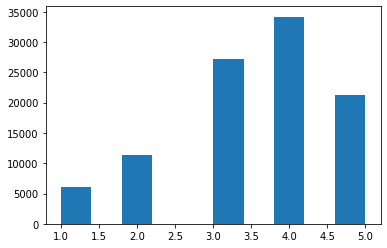

In [ ]:
import matplotlib.pyplot as plt
plt.hist(df['rating'])

## Content-based Filtering

---

Based on user (customer) history and feedback, calculate similarity

In [ ]:
import numpy as np
from surprise import Dataset
data = Dataset.load_builtin('ml-100k')
raw_data = np.array(data.raw_ratings, dtype=int)

In [ ]:
raw_data[:,0] -= 1
raw_data[:,1] -= 1

In [ ]:
n_users = np.max(raw_data[:,0])
n_movies = np.max(raw_data[:,1])
shape = (n_users + 1, n_movies + 1)
shape

(943, 1682)

### Adjacent matrix

In [ ]:
adj_matrix = np.ndarray(shape, dtype=int)
for user_id, movie_id, rating, time in raw_data:
  adj_matrix[user_id][movie_id] = 1.
adj_matrix

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]])

In [ ]:
my_id, my_vector = 0, adj_matrix[0]
best_match, best_match_id, best_match_vector = -1, -1, []
for user_id, user_vector in enumerate(adj_matrix):
  if my_id != user_id:
    similarity = np.dot(my_vector, user_vector)
    if similarity > best_match:
      best_match = similarity
      best_match_id = user_id
      best_match_vector = user_vector

print("Best Match: {}, Best Match ID: {}".format(best_match, best_match_id))

Best Match: 183, Best Match ID: 275


In [ ]:
recommend_list = []
for i, log in enumerate(zip(my_vector, best_match_vector)):
  log1, log2 = log 
  if log1 < 1. and log2 > 0.:
    recommend_list.append(i)
print(recommend_list)

[272, 273, 275, 280, 281, 283, 287, 288, 289, 290, 292, 293, 297, 299, 300, 301, 302, 306, 312, 314, 315, 316, 317, 321, 322, 323, 324, 327, 330, 331, 332, 333, 339, 342, 345, 346, 353, 354, 355, 356, 357, 363, 364, 365, 366, 372, 374, 378, 379, 381, 382, 383, 384, 385, 386, 387, 390, 391, 392, 394, 395, 396, 398, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 412, 414, 416, 417, 418, 419, 420, 422, 424, 425, 426, 427, 428, 430, 431, 432, 435, 442, 446, 447, 448, 449, 450, 451, 452, 454, 455, 457, 460, 461, 462, 468, 469, 470, 471, 472, 473, 474, 478, 495, 500, 507, 517, 522, 525, 530, 539, 540, 543, 545, 546, 548, 549, 550, 551, 553, 557, 558, 560, 561, 562, 563, 565, 566, 567, 568, 570, 571, 574, 575, 576, 577, 580, 581, 582, 585, 587, 589, 590, 594, 596, 602, 623, 626, 627, 630, 633, 635, 639, 646, 648, 651, 652, 654, 657, 664, 668, 671, 677, 678, 681, 683, 684, 685, 690, 691, 692, 695, 696, 708, 709, 714, 718, 719, 720, 724, 726, 727, 731, 733, 734, 736, 738, 741, 742, 745,

### Euclidean distance

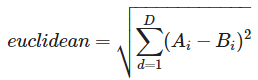

In [ ]:
my_id, my_vector = 0, adj_matrix[0]
best_match, best_match_id, best_match_vector = 9999, -1, []
for user_id, user_vector in enumerate(adj_matrix):
  if my_id != user_id:
    #similarity = np.dot(my_vector, user_vector)
    euclidean_dist = np.sqrt(np.sum(np.square(my_vector - user_vector)))
    #if similarity > best_match:
    if euclidean_dist < best_match:
      #best_match = similarity
      best_match = euclidean_dist
      best_match_id = user_id
      best_match_vector = user_vector

print("Best Match: {}, Best Match ID: {}".format(best_match, best_match_id))

Best Match: 14.832396974191326, Best Match ID: 737


In [ ]:
recommend_list = []
for i, log in enumerate(zip(my_vector, best_match_vector)):
  log1, log2 = log 
  if log1 < 1. and log2 > 0.:
    recommend_list.append(i)
print(recommend_list)

[297, 312, 317, 342, 356, 366, 379, 384, 392, 402, 404, 407, 417, 422, 428, 433, 448, 454, 469, 473, 495, 510, 516, 526, 527, 549, 567, 602, 635, 649, 650, 654, 658, 661, 664, 696, 731, 746, 750, 754, 915, 918, 925, 929, 950, 968, 1015, 1046]


### Cosine similarity

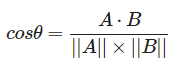

In [ ]:
def compute_cos_similarity(v1, v2):
  norm1 = np.sqrt(np.sum(np.square(v1)))
  norm2 = np.sqrt(np.sum(np.square(v2)))
  dot = np.dot(v1, v2)
  return dot / (norm1 * norm2)

In [ ]:
my_id, my_vector = 0, adj_matrix[0]
best_match, best_match_id, best_match_vector = -1, -1, []
for user_id, user_vector in enumerate(adj_matrix):
  if my_id != user_id:
    #similarity = np.dot(my_vector, user_vector)
    #euclidean_dist = np.sqrt(np.sum(np.square(my_vector - user_vector)))
    cos_similarity = compute_cos_similarity(my_vector, user_vector)
    #if similarity > best_match:
    #if euclidean_dist < best_match:
    if cos_similarity > best_match:
      #best_match = similarity
      #best_match = euclidean_dist
      best_match = cos_similarity
      best_match_id = user_id
      best_match_vector = user_vector

print("Best Match: {}, Best Match ID: {}".format(best_match, best_match_id))

Best Match: 0.5278586163659506, Best Match ID: 915


In [ ]:
recommend_list = []
for i, log in enumerate(zip(my_vector, best_match_vector)):
  log1, log2 = log 
  if log1 < 1. and log2 > 0.:
    recommend_list.append(i)
print(recommend_list)

[272, 275, 279, 280, 283, 285, 289, 294, 297, 316, 317, 355, 365, 366, 368, 379, 380, 381, 384, 386, 392, 398, 401, 404, 416, 420, 422, 424, 426, 427, 430, 432, 450, 460, 461, 466, 469, 471, 473, 474, 475, 479, 482, 483, 497, 505, 508, 510, 511, 522, 526, 527, 529, 530, 534, 536, 540, 545, 548, 549, 556, 557, 558, 560, 565, 567, 568, 569, 577, 580, 581, 582, 592, 596, 630, 635, 639, 641, 649, 651, 654, 673, 677, 678, 683, 684, 692, 696, 701, 703, 707, 708, 709, 712, 714, 719, 720, 726, 731, 734, 736, 738, 740, 745, 747, 754, 755, 761, 762, 763, 766, 780, 789, 791, 805, 819, 823, 824, 830, 843, 862, 865, 918, 929, 930, 938, 942, 943, 947, 958, 959, 960, 970, 977, 1004, 1008, 1009, 1010, 1013, 1041, 1045, 1069, 1072, 1073, 1078, 1097, 1100, 1108, 1112, 1118, 1134, 1193, 1205, 1207, 1216, 1219, 1267, 1334, 1400, 1427, 1596, 1681]


### adding feedback

In [ ]:
adj_matrix = np.ndarray(shape, dtype=int)
for user_id, movie_id, rating, time in raw_data:
  #adj_matrix[user_id][movie_id] = 1.
  adj_matrix[user_id][movie_id] = rating
adj_matrix

array([[5, 3, 4, ..., 0, 0, 0],
       [4, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [5, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 5, 0, ..., 0, 0, 0]])

In [ ]:
my_id, my_vector = 0, adj_matrix[0]
best_match, best_match_id, best_match_vector = 9999, -1, []
for user_id, user_vector in enumerate(adj_matrix):
  if my_id != user_id:
    #similarity = np.dot(my_vector, user_vector)
    euclidean_dist = np.sqrt(np.sum(np.square(my_vector - user_vector)))
    #if similarity > best_match:
    if euclidean_dist < best_match:
      #best_match = similarity
      best_match = euclidean_dist
      best_match_id = user_id
      best_match_vector = user_vector

print("Best Match: {}, Best Match ID: {}".format(best_match, best_match_id))

Best Match: 55.06359959174482, Best Match ID: 737


In [ ]:
my_id, my_vector = 0, adj_matrix[0]
best_match, best_match_id, best_match_vector = -1, -1, []
for user_id, user_vector in enumerate(adj_matrix):
  if my_id != user_id:
    #similarity = np.dot(my_vector, user_vector)
    #euclidean_dist = np.sqrt(np.sum(np.square(my_vector - user_vector)))
    cos_similarity = compute_cos_similarity(my_vector, user_vector)
    #if similarity > best_match:
    #if euclidean_dist < best_match:
    if cos_similarity > best_match:
      #best_match = similarity
      #best_match = euclidean_dist
      best_match = cos_similarity
      best_match_id = user_id
      best_match_vector = user_vector

print("Best Match: {}, Best Match ID: {}".format(best_match, best_match_id))

Best Match: 0.569065731527988, Best Match ID: 915


## Collaborative Filtering


In [ ]:
from surprise import Dataset
data = Dataset.load_builtin('ml-100k')

### KNN

In [ ]:
from surprise import KNNBasic
from surprise.model_selection import cross_validate
model = KNNBasic()
cross_validate(model, data, measures=['rmse', 'mae'], cv=5, n_jobs=4, verbose=True)

Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9789  0.9844  0.9794  0.9837  0.9700  0.9793  0.0051  
MAE (testset)     0.7718  0.7773  0.7723  0.7766  0.7674  0.7731  0.0036  
Fit time          0.49    0.82    0.83    0.85    0.78    0.75    0.13    
Test time         7.09    8.30    8.49    6.48    4.16    6.90    1.56    


{'fit_time': (0.493513822555542,
  0.8171682357788086,
  0.8270130157470703,
  0.8470032215118408,
  0.7836227416992188),
 'test_mae': array([0.77175651, 0.77725766, 0.77226712, 0.77661577, 0.76735643]),
 'test_rmse': array([0.97886553, 0.98442863, 0.97940809, 0.98370834, 0.97004253]),
 'test_time': (7.085634231567383,
  8.304140329360962,
  8.492968082427979,
  6.483105182647705,
  4.156208515167236)}

### SVD

In [ ]:
from surprise import SVD
from surprise.model_selection import cross_validate
model = SVD()
cross_validate(model, data, measures=['rmse', 'mae'], cv=5, n_jobs=4, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9333  0.9384  0.9357  0.9387  0.9395  0.9371  0.0023  
MAE (testset)     0.7374  0.7424  0.7375  0.7375  0.7402  0.7390  0.0020  
Fit time          12.04   15.15   15.24   12.47   8.24    12.63   2.56    
Test time         0.60    0.60    0.36    0.30    0.16    0.40    0.17    


{'fit_time': (12.035125017166138,
  15.153148889541626,
  15.239967107772827,
  12.468018293380737,
  8.242295742034912),
 'test_mae': array([0.73738135, 0.74242514, 0.73750996, 0.73754085, 0.74019494]),
 'test_rmse': array([0.93334159, 0.93840127, 0.93571976, 0.93867869, 0.9394918 ]),
 'test_time': (0.5967376232147217,
  0.5986969470977783,
  0.36158275604248047,
  0.30399608612060547,
  0.16253042221069336)}

### NMF

In [ ]:
from surprise import NMF
from surprise.model_selection import cross_validate
model = NMF()
cross_validate(model, data, measures=['rmse', 'mae'], cv=5, n_jobs=4, verbose=True)

Evaluating RMSE, MAE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9663  0.9613  0.9680  0.9664  0.9674  0.9659  0.0024  
MAE (testset)     0.7578  0.7575  0.7597  0.7589  0.7618  0.7591  0.0016  
Fit time          13.41   16.03   16.39   13.50   8.80    13.63   2.71    
Test time         0.64    0.52    0.36    0.24    0.14    0.38    0.18    


{'fit_time': (13.414676904678345,
  16.034263610839844,
  16.393381118774414,
  13.495818614959717,
  8.800899267196655),
 'test_mae': array([0.75775041, 0.7574886 , 0.75966403, 0.7589445 , 0.76179787]),
 'test_rmse': array([0.96631989, 0.96127946, 0.96799866, 0.96643549, 0.96743483]),
 'test_time': (0.6445057392120361,
  0.5151314735412598,
  0.36005663871765137,
  0.23765802383422852,
  0.14273715019226074)}

### SVD++

In [ ]:
from surprise import SVDpp
from surprise.model_selection import cross_validate
model = SVDpp()
cross_validate(model, data, measures=['rmse', 'mae'], cv=5, n_jobs=4, verbose=True)

Evaluating RMSE, MAE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9112  0.9157  0.9131  0.9230  0.9351  0.9196  0.0087  
MAE (testset)     0.7160  0.7175  0.7171  0.7233  0.7336  0.7215  0.0066  
Fit time          666.18  670.80  670.22  676.34  170.61  570.83  200.14  
Test time         12.29   12.97   11.78   6.28    3.24    9.31    3.86    


{'fit_time': (666.1783828735352,
  670.7973039150238,
  670.2176167964935,
  676.3375568389893,
  170.6071753501892),
 'test_mae': array([0.71601245, 0.71747778, 0.71705826, 0.7232679 , 0.73360002]),
 'test_rmse': array([0.91117747, 0.91571346, 0.91310341, 0.92302806, 0.93509196]),
 'test_time': (12.292191505432129,
  12.973945140838623,
  11.784970998764038,
  6.280825138092041,
  3.2426886558532715)}

## Hybrid

Possible to make various hybrid (Content-based + Collaborative) system

In [ ]:
import numpy as np
from surprise import Dataset
data = Dataset.load_builtin('ml-100k')
raw_data = np.array(data.raw_ratings, dtype=int)
raw_data[:,0] -= 1
raw_data[:,1] -= 1

In [ ]:
n_users = np.max(raw_data[:,0])
n_movies = np.max(raw_data[:,1])
shape = (n_users + 1, n_movies + 1)
shape

(943, 1682)

In [ ]:
adj_matrix = np.ndarray(shape, dtype=int)
for user_id, movie_id, rating, time in raw_data:
  adj_matrix[user_id][movie_id] = rating
adj_matrix

array([[5, 3, 4, ..., 0, 0, 0],
       [4, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [5, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 5, 0, ..., 0, 0, 0]])

### For instance, SVD (Collaborate) + Cosine (Content-based)

In [ ]:
from sklearn.decomposition import randomized_svd
U, S, V = randomized_svd(adj_matrix, n_components=2)
S = np.diag(S)
print(U.shape)
print(S.shape)
print(V.shape)

(943, 2)
(2, 2)
(2, 1682)


In [ ]:
np.matmul(np.matmul(U, S), V)

array([[ 3.91732663e+00,  1.47276644e+00,  7.98261988e-01, ...,
         6.24907189e-04,  1.41100852e-02,  1.36545878e-02],
       [ 1.85777226e+00,  3.96191175e-01,  5.05705740e-01, ...,
         5.38862978e-03,  1.77237914e-03,  5.26968095e-04],
       [ 8.94989517e-01,  1.71578497e-01,  2.51738682e-01, ...,
         2.92094923e-03,  5.39937171e-04, -1.25733753e-04],
       ...,
       [ 9.92051955e-01,  2.10814957e-01,  2.70363365e-01, ...,
         2.89019297e-03,  9.34221962e-04,  2.66612193e-04],
       [ 1.30425401e+00,  5.27669941e-01,  2.50080165e-01, ...,
        -4.20677765e-04,  5.30525683e-03,  5.28069948e-03],
       [ 2.82999397e+00,  9.70812247e-01,  6.15871694e-01, ...,
         2.02091492e-03,  8.67740813e-03,  8.03107892e-03]])

**User-based recommendation**

---



In [ ]:
def compute_cos_similarity(v1, v2):
  norm1 = np.sqrt(np.sum(np.square(v1)))
  norm2 = np.sqrt(np.sum(np.square(v2)))
  dot = np.dot(v1, v2)
  return dot / (norm1 * norm2)

In [ ]:
my_id, my_vector = 0, U[0]
best_match, best_match_id, best_match_vector = -1, -1, []
for user_id, user_vector in enumerate(U):
  if my_id != user_id:
    #similarity = np.dot(my_vector, user_vector)
    #euclidean_dist = np.sqrt(np.sum(np.square(my_vector - user_vector)))
    cos_similarity = compute_cos_similarity(my_vector, user_vector)
    #if similarity > best_match:
    #if euclidean_dist < best_match:
    if cos_similarity > best_match:
      #best_match = similarity
      #best_match = euclidean_dist
      best_match = cos_similarity
      best_match_id = user_id
      best_match_vector = user_vector

print("Best Match: {}, Best Match ID: {}".format(best_match, best_match_id))

Best Match: 0.9999942295956324, Best Match ID: 235


In [ ]:
recommend_list = []
#for i, log in enumerate(zip(my_vector, best_match_vector)):
for i, log in enumerate(zip(adj_matrix[my_id], adj_matrix[best_match_id])):
  log1, log2 = log 
  if log1 < 1. and log2 > 0.:
    recommend_list.append(i)
print(recommend_list)

[272, 273, 274, 281, 285, 288, 293, 297, 303, 306, 312, 317, 327, 332, 369, 410, 418, 419, 422, 426, 428, 431, 434, 442, 461, 475, 477, 482, 495, 503, 504, 505, 506, 509, 519, 520, 522, 525, 531, 545, 548, 590, 594, 595, 613, 631, 654, 658, 660, 672, 684, 685, 691, 695, 698, 704, 716, 728, 734, 749, 755, 863, 865, 933, 1012, 1038, 1101, 1327, 1400]


**Item-based recommendation**

---



In [ ]:
my_id, my_vector = 0, V.T[0]
best_match, best_match_id, best_match_vector = -1, -1, []
for user_id, user_vector in enumerate(V.T):
  if my_id != user_id:
    #similarity = np.dot(my_vector, user_vector)
    #euclidean_dist = np.sqrt(np.sum(np.square(my_vector - user_vector)))
    cos_similarity = compute_cos_similarity(my_vector, user_vector)
    #if similarity > best_match:
    #if euclidean_dist < best_match:
    if cos_similarity > best_match:
      #best_match = similarity
      #best_match = euclidean_dist
      best_match = cos_similarity
      best_match_id = user_id
      best_match_vector = user_vector

print("Best Match: {}, Best Match ID: {}".format(best_match, best_match_id))

Best Match: 0.9999999951364145, Best Match ID: 1287


In [ ]:
recommend_list = []
#for i, log in enumerate(zip(my_vector, best_match_vector)):
#for i, log in enumerate(zip(adj_matrix[my_id], adj_matrix[best_match_id])):
for i, user_vector in enumerate(adj_matrix):
  #log1, log2 = log 
  #if log1 < 1. and log2 > 0.:
  if adj_matrix[i][my_id] > 0.9:
    recommend_list.append(i)
print(recommend_list)

[0, 1, 4, 5, 9, 12, 14, 15, 16, 17, 19, 20, 22, 24, 25, 37, 40, 41, 42, 43, 44, 48, 53, 55, 56, 57, 58, 61, 62, 63, 64, 65, 66, 69, 71, 72, 74, 76, 78, 80, 81, 82, 83, 88, 91, 92, 93, 94, 95, 96, 98, 100, 101, 105, 107, 108, 116, 119, 120, 123, 124, 127, 129, 130, 133, 136, 137, 140, 143, 144, 147, 149, 150, 156, 157, 159, 161, 167, 173, 176, 177, 180, 181, 183, 188, 192, 193, 197, 198, 199, 200, 201, 202, 203, 208, 209, 212, 215, 221, 222, 229, 230, 231, 233, 234, 241, 242, 243, 245, 246, 247, 248, 249, 250, 251, 252, 253, 255, 261, 262, 264, 267, 270, 273, 274, 275, 276, 278, 279, 285, 286, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 300, 302, 304, 306, 307, 310, 311, 312, 313, 319, 321, 323, 324, 325, 326, 329, 330, 331, 335, 337, 338, 339, 342, 343, 344, 346, 347, 349, 356, 358, 359, 362, 364, 370, 373, 377, 378, 379, 380, 386, 387, 388, 389, 392, 393, 394, 395, 397, 398, 400, 401, 402, 405, 406, 410, 411, 415, 416, 418, 421, 423, 424, 428, 431, 433, 434, 437, 440, 444, 

### For instance, Non-negative factorization (Collaborate) + Cosine (Content-based)

In [ ]:
from sklearn.decomposition import non_negative_factorization
A, B, iter = non_negative_factorization(adj_matrix, n_components=2)

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1035: FutureWarning: The default value of init will change from random to None in 0.23 to make it consistent with decomposition.NMF.
  "with decomposition.NMF.", FutureWarning)


In [ ]:
np.matmul(A, B)

array([[3.71104337e+00, 1.48478758e+00, 7.39555123e-01, ...,
        3.64526629e-03, 1.45529533e-02, 1.44127764e-02],
       [2.11741174e+00, 2.36725022e-01, 5.51609294e-01, ...,
        4.76723612e-03, 2.43256703e-05, 0.00000000e+00],
       [9.85439886e-01, 1.10171430e-01, 2.56718044e-01, ...,
        2.21866373e-03, 1.13211263e-05, 0.00000000e+00],
       ...,
       [1.04462347e+00, 1.16788109e-01, 2.72136025e-01, ...,
        2.35191231e-03, 1.20010509e-05, 0.00000000e+00],
       [1.45792157e+00, 5.42098660e-01, 2.99294725e-01, ...,
        1.61352075e-03, 5.15829880e-03, 5.10698651e-03],
       [2.44659568e+00, 9.41431478e-01, 4.95523131e-01, ...,
        2.56809849e-03, 9.08646615e-03, 8.99746557e-03]])

**User-based recommendation**

---


In [ ]:
my_id, my_vector = 0, U[0]
best_match, best_match_id, best_match_vector = -1, -1, []
for user_id, user_vector in enumerate(U):
  if my_id != user_id:
    #similarity = np.dot(my_vector, user_vector)
    #euclidean_dist = np.sqrt(np.sum(np.square(my_vector - user_vector)))
    cos_similarity = compute_cos_similarity(my_vector, user_vector)
    #if similarity > best_match:
    #if euclidean_dist < best_match:
    if cos_similarity > best_match:
      #best_match = similarity
      #best_match = euclidean_dist
      best_match = cos_similarity
      best_match_id = user_id
      best_match_vector = user_vector

print("Best Match: {}, Best Match ID: {}".format(best_match, best_match_id))

Best Match: 0.9999942295956324, Best Match ID: 235


In [ ]:
recommend_list = []
#for i, log in enumerate(zip(my_vector, best_match_vector)):
for i, log in enumerate(zip(adj_matrix[my_id], adj_matrix[best_match_id])):
  log1, log2 = log 
  if log1 < 1. and log2 > 0.:
    recommend_list.append(i)
print(recommend_list)

[272, 273, 274, 281, 285, 288, 293, 297, 303, 306, 312, 317, 327, 332, 369, 410, 418, 419, 422, 426, 428, 431, 434, 442, 461, 475, 477, 482, 495, 503, 504, 505, 506, 509, 519, 520, 522, 525, 531, 545, 548, 590, 594, 595, 613, 631, 654, 658, 660, 672, 684, 685, 691, 695, 698, 704, 716, 728, 734, 749, 755, 863, 865, 933, 1012, 1038, 1101, 1327, 1400]


**Item-based recommendation**

---



In [ ]:
my_id, my_vector = 0, V.T[0]
best_match, best_match_id, best_match_vector = -1, -1, []
for user_id, user_vector in enumerate(V.T):
  if my_id != user_id:
    #similarity = np.dot(my_vector, user_vector)
    #euclidean_dist = np.sqrt(np.sum(np.square(my_vector - user_vector)))
    cos_similarity = compute_cos_similarity(my_vector, user_vector)
    #if similarity > best_match:
    #if euclidean_dist < best_match:
    if cos_similarity > best_match:
      #best_match = similarity
      #best_match = euclidean_dist
      best_match = cos_similarity
      best_match_id = user_id
      best_match_vector = user_vector

print("Best Match: {}, Best Match ID: {}".format(best_match, best_match_id))

Best Match: 0.9999999951364145, Best Match ID: 1287


In [ ]:
recommend_list = []
#for i, log in enumerate(zip(my_vector, best_match_vector)):
#for i, log in enumerate(zip(adj_matrix[my_id], adj_matrix[best_match_id])):
for i, user_vector in enumerate(adj_matrix):
  #log1, log2 = log 
  #if log1 < 1. and log2 > 0.:
  if adj_matrix[i][my_id] > 0.9:
    recommend_list.append(i)
print(recommend_list)

[0, 1, 4, 5, 9, 12, 14, 15, 16, 17, 19, 20, 22, 24, 25, 37, 40, 41, 42, 43, 44, 48, 53, 55, 56, 57, 58, 61, 62, 63, 64, 65, 66, 69, 71, 72, 74, 76, 78, 80, 81, 82, 83, 88, 91, 92, 93, 94, 95, 96, 98, 100, 101, 105, 107, 108, 116, 119, 120, 123, 124, 127, 129, 130, 133, 136, 137, 140, 143, 144, 147, 149, 150, 156, 157, 159, 161, 167, 173, 176, 177, 180, 181, 183, 188, 192, 193, 197, 198, 199, 200, 201, 202, 203, 208, 209, 212, 215, 221, 222, 229, 230, 231, 233, 234, 241, 242, 243, 245, 246, 247, 248, 249, 250, 251, 252, 253, 255, 261, 262, 264, 267, 270, 273, 274, 275, 276, 278, 279, 285, 286, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 300, 302, 304, 306, 307, 310, 311, 312, 313, 319, 321, 323, 324, 325, 326, 329, 330, 331, 335, 337, 338, 339, 342, 343, 344, 346, 347, 349, 356, 358, 359, 362, 364, 370, 373, 377, 378, 379, 380, 386, 387, 388, 389, 392, 393, 394, 395, 397, 398, 400, 401, 402, 405, 406, 410, 411, 415, 416, 418, 421, 423, 424, 428, 431, 433, 434, 437, 440, 444, 